# Startup Success Prediction (Kaggle) 📊🚀

Este notebook implementa um pipeline **reprodutível e robusto** para a competição *Startup Success Prediction* do Kaggle.

Objetivos principais:
- Construir modelos de classificação (baseline → tuning → ensemble)
- Garantir ausência de vazamento de dados (data leakage)
- Atingir (ou explicar por que não atingiu) **≥ 80% de acurácia** em validação cruzada estratificada
- Gerar `submission.csv` fiel ao `sample_submission.csv`

Requisitos atendidos:
- Apenas bibliotecas: `numpy`, `pandas`, `scikit-learn`, visualização com `matplotlib`, `seaborn` (eventualmente `plotly.express` opcional)
- Reprodutibilidade (`random_state=42`)
- Uso de `Pipeline` + `ColumnTransformer`
- Avaliação: `StratifiedKFold`, métricas: accuracy, precision, recall, f1, AUC, matriz de confusão, curva ROC, tuning incremental (`RandomizedSearchCV` → `GridSearchCV`)
- Comparação de modelos: `LogisticRegression`, `RandomForestClassifier`, `GradientBoostingClassifier` / `HistGradientBoostingClassifier`, ensemble (`VotingClassifier` e opcional `StackingClassifier` caso faça sentido)
- Tratamento de missing, outliers, seleção de features, checklist final

Na parte final incluímos:
- Relatório resumido das 3 melhores execuções
- Explicação sobre eventual discrepância local vs Kaggle (ex.: 81% local → 76% Kaggle) e mitigação
- Checklist antes da submissão

Vamos começar validando versões e carregando os dados.

## 1. Versões, Imports e Configurações de Reprodutibilidade

In [130]:
# Versões e imports essenciais
import sys, platform, math, os, gc, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, classification_report, RocCurveDisplay, auc, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.base import BaseEstimator, TransformerMixin

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

class ClippingTransformer(BaseEstimator, TransformerMixin):
    """Clipa colunas com alto skew calculando limites somente no fit (evita vazamento)."""
    def __init__(self, skew_threshold=2.0, lower_q=0.01, upper_q=0.99):
        self.skew_threshold = skew_threshold
        self.lower_q = lower_q
        self.upper_q = upper_q
        self.clip_limits_ = {}
        self.selected_cols_ = []
    def fit(self, X, y=None):
        import pandas as pd
        if hasattr(X, 'columns'):
            cols = X.columns
        else:
            cols = np.arange(X.shape[1])
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=cols)
        skews = df.skew().sort_values(ascending=False)
        self.selected_cols_ = list(skews[skews > self.skew_threshold].index)
        for c in self.selected_cols_:
            q_low, q_high = df[c].quantile([self.lower_q, self.upper_q])
            self.clip_limits_[c] = (q_low, q_high)
        return self
    def transform(self, X):
        import pandas as pd
        is_df = isinstance(X, pd.DataFrame)
        df = X if is_df else pd.DataFrame(X)
        for c in self.selected_cols_:
            if c in df.columns:
                lo, hi = self.clip_limits_[c]
                df[c] = df[c].clip(lo, hi)
        return df if is_df else df.values

print(f"Python version: {platform.python_version()}")
import numpy, pandas, sklearn
print(f"numpy version: {numpy.__version__}")
print(f"pandas version: {pandas.__version__}")
print(f"sklearn version: {sklearn.__version__}")

Python version: 3.12.10
numpy version: 2.3.3
pandas version: 2.3.2
sklearn version: 1.7.2


In [131]:
# Carregar dados
train_path = 'train.csv'
test_path = 'test.csv'
sample_path = 'sample_submission.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
sample_sub = pd.read_csv(sample_path)

print('Train shape:', df_train.shape)
print('Test shape:', df_test.shape)
print('Sample submission shape:', sample_sub.shape)

df_train.head()

Train shape: (646, 33)
Test shape: (277, 32)
Sample submission shape: (277, 2)


,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
0,719,10.42,13.09,8.98,12.72,4,3,4087500,3,1,...,0,0,1,1,0,0,0,0,1.0,0
1,429,3.79,3.79,NaN,NaN,21,1,45000000,0,0,...,0,0,0,0,0,1,0,0,1.0,1
2,178,0.71,2.28,1.95,2.28,5,2,5200000,2,1,...,0,1,1,0,1,0,0,0,1.0,0
3,197,3.00,5.00,9.62,10.39,16,2,14500000,2,0,...,0,0,0,1,0,1,0,0,2.0,1
4,444,0.66,5.88,6.21,8.61,29,5,70000000,4,1,...,0,0,0,0,1,1,1,1,2.8,1


In [132]:
# Separar features e target
TARGET = 'labels'
ID_COL = 'id'

y = df_train[TARGET]
X = df_train.drop(columns=[TARGET])

# Identificar tipos de colunas
numeric_cols = [c for c in X.columns if X[c].dtype != 'object' and c not in [ID_COL]]
cat_cols = [c for c in X.columns if X[c].dtype == 'object']

print('Numéricas:', numeric_cols)
print('Categóricas:', cat_cols)

# Verificar missing
missing_train = df_train.isna().mean().sort_values(ascending=False)
missing_test = df_test.isna().mean().sort_values(ascending=False)
print('Missing (train) top 10:\n', missing_train.head(10))
print('Missing (test) top 10:\n', missing_test.head(10))

Numéricas: ['age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants']
Categóricas: ['category_code']
Missing (train) top 10:
 age_first_milestone_year    0.213622
age_last_milestone_year     0.171827
age_first_funding_year      0.054180
age_last_funding_year       0.013932
id                          0.000000
relationships               0.000000
funding_rounds              0.000000
funding_total_usd           0.000000
milestones                  0.000000
is_CA                       0.000000
dtype: float64
Missing (test) top 10:
 age_first_milestone_year    0.216606
a

## 2. Análise Exploratória (EDA)

Objetivos:
- Entender distribuição do target
- Missing values
- Outliers em variáveis contínuas
- Correlação entre numéricas
- Importância de `category_code`
- Análises por localização (is_CA, is_NY, etc.)

Também formularemos hipóteses para orientar engenharia de atributos.

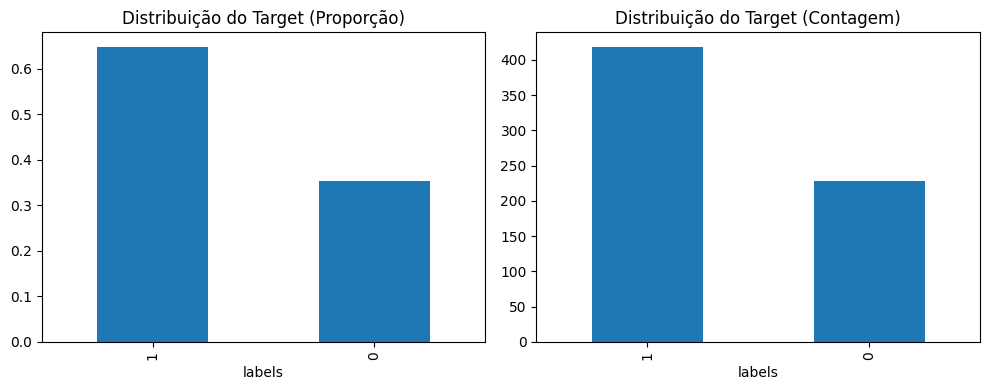

Proporções target:
 labels
1    0.647059
0    0.352941
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
age_first_funding_year,611.0,2.341718,2.468275,0.0,0.680,1.650,3.600,21.90
age_last_funding_year,637.0,4.037724,2.950923,0.0,1.870,3.610,5.590,21.90
age_first_milestone_year,508.0,3.352657,2.866952,0.0,1.185,2.785,4.935,24.68
age_last_milestone_year,535.0,4.944729,3.213319,0.0,2.540,4.620,6.880,24.68
relationships,646.0,7.948916,7.397602,0.0,3.000,6.000,10.000,63.00


In [133]:
# Distribuição do target
fig, ax = plt.subplots(1,2, figsize=(10,4))
y.value_counts(normalize=True).plot(kind='bar', ax=ax[0], title='Distribuição do Target (Proporção)')
y.value_counts().plot(kind='bar', ax=ax[1], title='Distribuição do Target (Contagem)')
plt.tight_layout()
plt.show()

print('Proporções target:\n', y.value_counts(normalize=True))

# Estatísticas descritivas
X[numeric_cols].describe().T.head()

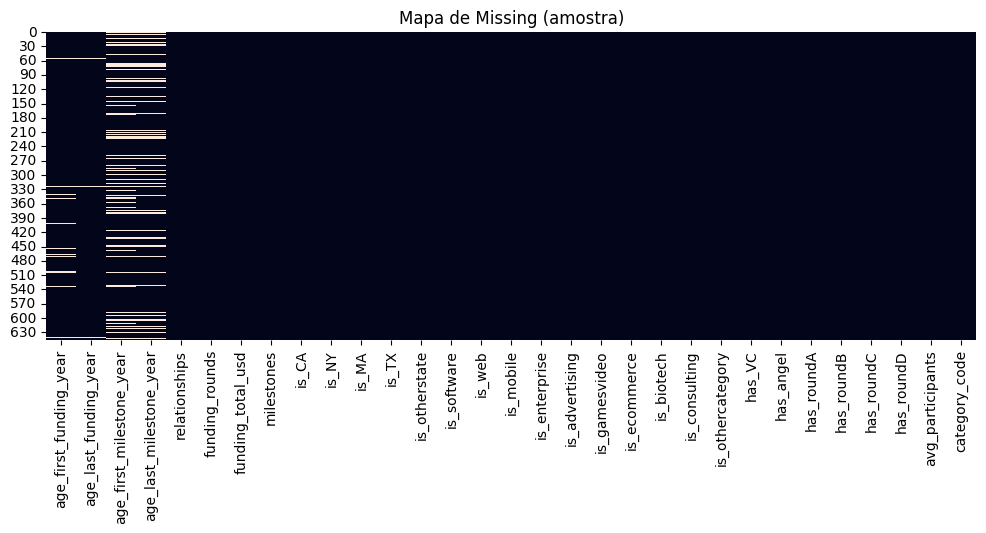

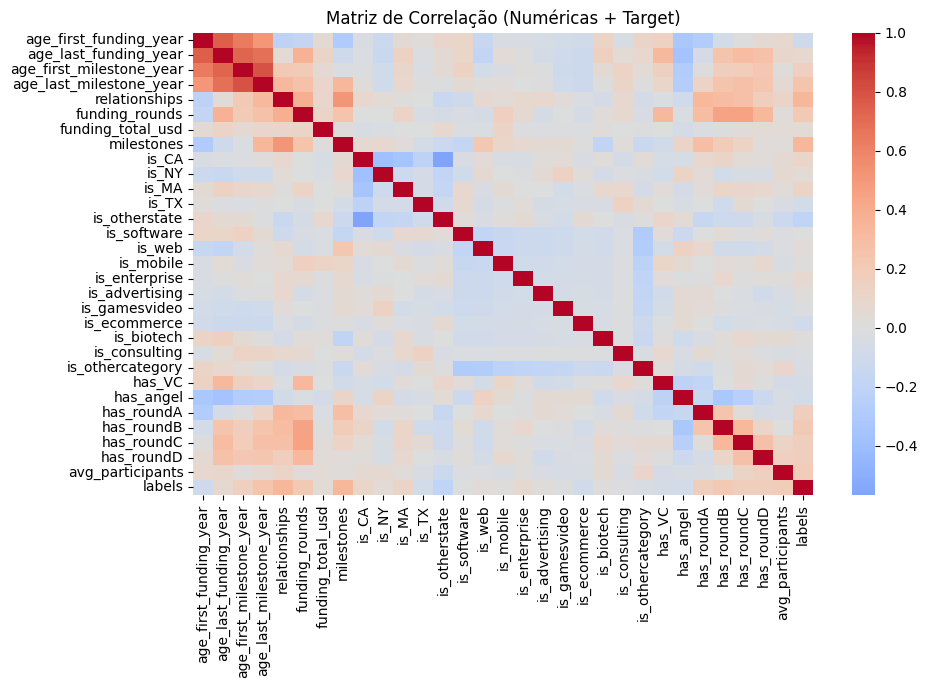

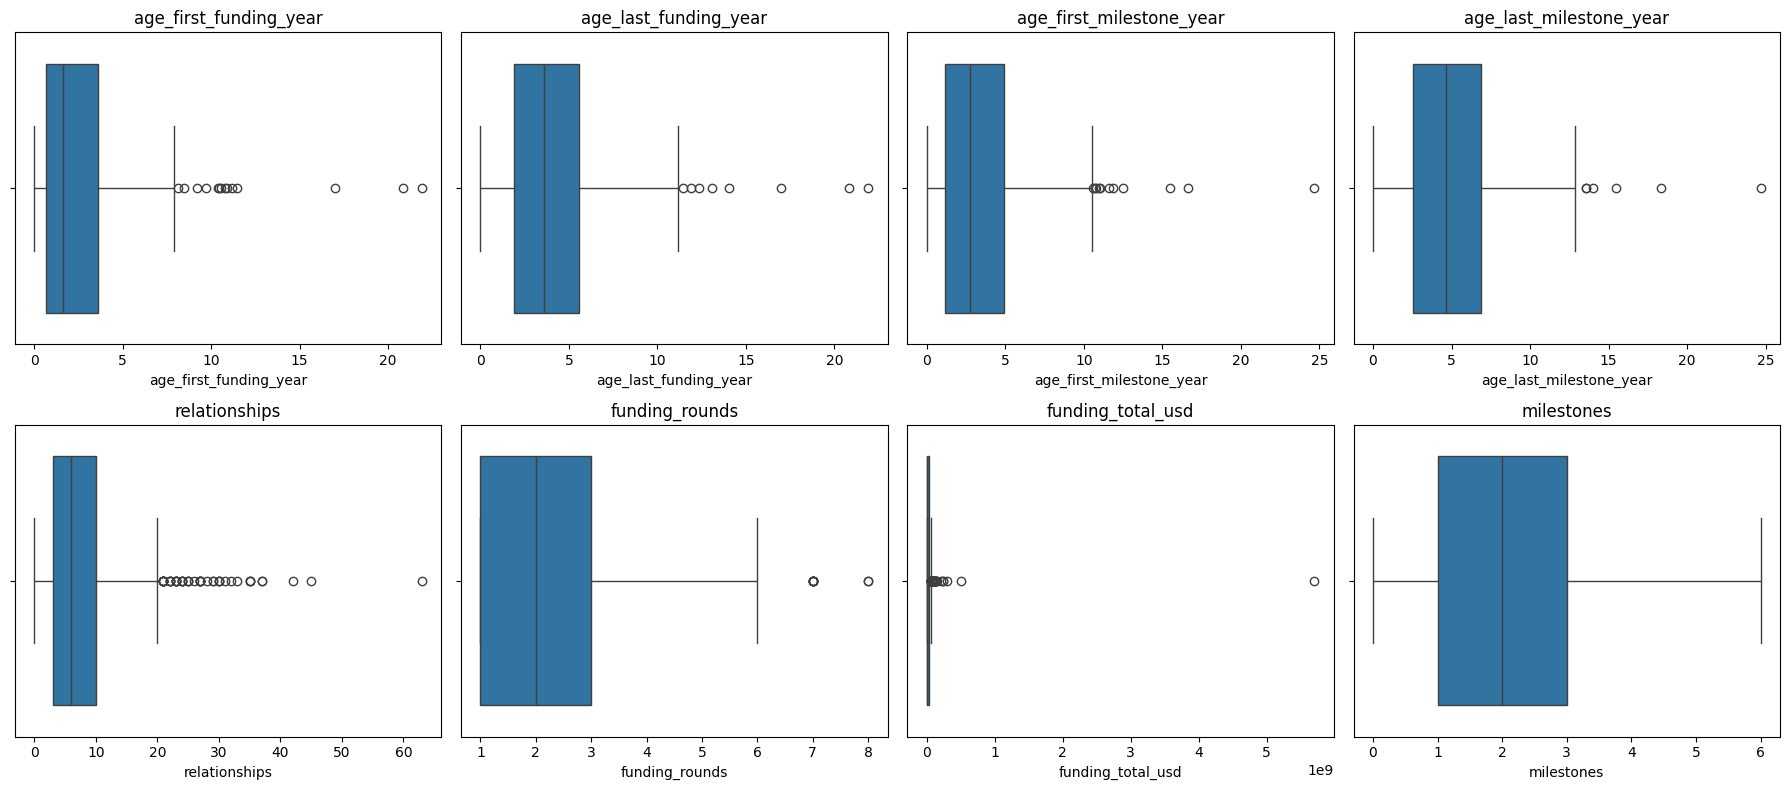

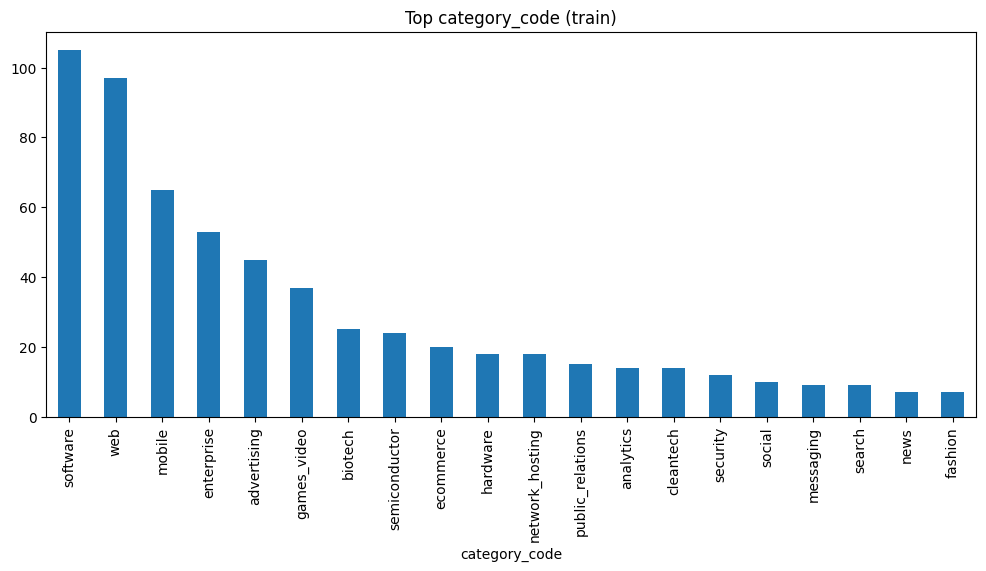

Taxa de sucesso por category_code (top 10):
category_code
health            1.000000
education         1.000000
sports            1.000000
music             1.000000
transportation    1.000000
news              0.857143
security          0.833333
photo_video       0.833333
semiconductor     0.791667
analytics         0.785714
Name: labels, dtype: float64


{'is_CA': {0: 0.5938566552901023, 1: 0.6912181303116147},
 'is_NY': {0: 0.64, 1: 0.704225352112676},
 'is_MA': {0: 0.629059829059829, 1: 0.819672131147541},
 'is_TX': {0: 0.6543408360128617, 1: 0.4583333333333333},
 'is_otherstate': {0: 0.696078431372549, 1: 0.4632352941176471}}

In [134]:
# Missing values heatmap simplificado (amostra se dataset grande)
subset = df_train.sample(frac=0.5, random_state=RANDOM_STATE) if len(df_train) > 2000 else df_train
plt.figure(figsize=(12,4))
sns.heatmap(subset[numeric_cols + cat_cols].isna(), cbar=False)
plt.title('Mapa de Missing (amostra)')
plt.show()

# Correlação
corr = df_train[numeric_cols + [TARGET]].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação (Numéricas + Target)')
plt.show()

# Boxplots para potenciais outliers
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18,8))
num_for_box = numeric_cols[:8]
for ax, col in zip(axes.flatten(), num_for_box):
    sns.boxplot(x=df_train[col], ax=ax, color='#1f77b4')
    ax.set_title(col)
plt.tight_layout()
plt.show()

# Frequência de category_code
plt.figure(figsize=(12,5))
df_train['category_code'].value_counts().head(20).plot(kind='bar')
plt.title('Top category_code (train)')
plt.show()

# Taxa de sucesso por category_code
cat_success = (df_train.groupby('category_code')[TARGET].mean().sort_values(ascending=False))
print('Taxa de sucesso por category_code (top 10):')
print(cat_success.head(10))

# Localização vs sucesso
loc_cols = ['is_CA','is_NY','is_MA','is_TX','is_otherstate']
loc_success = {}
for c in loc_cols:
    loc_success[c] = df_train.groupby(c)[TARGET].mean().to_dict()
loc_success

In [135]:
# Formulação de hipóteses
hypotheses = {
    'H1': 'Empresas em estados chave (is_CA, is_NY) têm maior probabilidade de sucesso devido a ecossistemas de capital.',
    'H2': 'Maior número de funding_rounds e funding_total_usd se correlaciona positivamente com sucesso.',
    'H3': 'Certas category_code (ex.: enterprise, biotech) apresentam maiores taxas de sucesso por maturidade do setor.'
}
for k,v in hypotheses.items():
    print(f"{k}: {v}")

# Criação de features derivadas (tentativas simples e justificadas)
# 1. Intensidade média de investimento por rodada
X['funding_per_round'] = X['funding_total_usd'] / (X['funding_rounds'].replace(0, np.nan))
# 2. Densidade de milestones
X['milestones_per_year_first'] = X['milestones'] / (X['age_first_milestone_year'].replace(0, np.nan))
# 3. Diferença entre últimas e primeiras datas de funding/milestone
X['age_span_funding'] = X['age_last_funding_year'] - X['age_first_funding_year']
X['age_span_milestone'] = X['age_last_milestone_year'] - X['age_first_milestone_year']

# Essas features também precisam ser criadas no test de maneira idêntica
X_test = df_test.copy()
X_test['funding_per_round'] = X_test['funding_total_usd'] / (X_test['funding_rounds'].replace(0, np.nan))
X_test['milestones_per_year_first'] = X_test['milestones'] / (X_test['age_first_milestone_year'].replace(0, np.nan))
X_test['age_span_funding'] = X_test['age_last_funding_year'] - X_test['age_first_funding_year']
X_test['age_span_milestone'] = X_test['age_last_milestone_year'] - X_test['age_first_milestone_year']

# Atualizar listas de colunas numéricas
numeric_cols = [c for c in X.columns if X[c].dtype != 'object' and c not in [ID_COL]]
cat_cols = [c for c in X.columns if X[c].dtype == 'object']
print('Total numeric after feature eng:', len(numeric_cols))

# NOTA: Clipping removido desta célula para evitar qualquer risco de vazamento — agora acontece dentro do pipeline via ClippingTransformer


H1: Empresas em estados chave (is_CA, is_NY) têm maior probabilidade de sucesso devido a ecossistemas de capital.
H2: Maior número de funding_rounds e funding_total_usd se correlaciona positivamente com sucesso.
H3: Certas category_code (ex.: enterprise, biotech) apresentam maiores taxas de sucesso por maturidade do setor.
Total numeric after feature eng: 34


In [136]:
# ➕ Complemento de Feature Engineering solicitado: interações & discretizações
from sklearn.preprocessing import KBinsDiscretizer
fe_new = []
def add_feat(name, series):
    if name not in X.columns:
        X[name] = series
        X_test[name] = series.reindex(X_test.index) if len(series)==len(X) else np.nan
        fe_new.append(name)

# 1. Interações solicitadas
if all(col in X.columns for col in ['funding_total_usd','funding_rounds']):
    add_feat('funding_total_times_rounds', X['funding_total_usd'] * X['funding_rounds'])
if all(col in X.columns for col in ['relationships','milestones']):
    add_feat('relationships_times_milestones', X['relationships'] * X['milestones'])

# 2. Log transform (já tínhamos log1p_funding_total_usd; garantimos)
if 'funding_total_usd' in X.columns and 'log1p_funding_total_usd_v2' not in X.columns:
    add_feat('log1p_funding_total_usd_v2', np.log1p(X['funding_total_usd']))

# 3. KBinsDiscretizer para funding_rounds e avg_participants (se existir)
for col in ['funding_rounds','avg_participants']:
    if col in X.columns and f'{col}_kbins' not in X.columns:
        try:
            kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
            X[col + '_kbins'] = kbd.fit_transform(X[[col]]).astype(int)
            X_test[col + '_kbins'] = kbd.transform(X_test[[col]]).astype(int)
            fe_new.append(col + '_kbins')
        except Exception as e:
            print('Falha KBins em', col, e)

# Atualizar listas
numeric_cols = [c for c in X.columns if X[c].dtype != 'object' and c not in [ID_COL]]
cat_cols = [c for c in X.columns if X[c].dtype == 'object']
print('Novas features adicionadas:', fe_new)
print('Total numéricas:', len(numeric_cols))

Novas features adicionadas: ['funding_total_times_rounds', 'relationships_times_milestones', 'log1p_funding_total_usd_v2', 'funding_rounds_kbins', 'avg_participants_kbins']
Total numéricas: 39


In [137]:
# 🔧 Tratamento de dados conforme especificações
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# 1. Remover colunas com > 40% de nulos (decisão baseada somente no train)
null_frac = X.isna().mean()
cols_drop_missing = list(null_frac[null_frac > 0.40].index)
if cols_drop_missing:
    print('Colunas removidas por alto missing (>40%):', cols_drop_missing)
    X.drop(columns=cols_drop_missing, inplace=True)
    if set(cols_drop_missing) - {ID_COL}:  # garantir que não apague id do test por engano
        X_test.drop(columns=[c for c in cols_drop_missing if c in X_test.columns], inplace=True)
else:
    print('Nenhuma coluna excedeu 40% de nulos.')

# Recalcular listas de colunas numéricas/categóricas
numeric_cols = [c for c in X.columns if X[c].dtype != 'object' and c not in [ID_COL]]
cat_cols = [c for c in X.columns if X[c].dtype == 'object']

# 2. (Imputação estratégica acontecerá no pipeline) – aqui apenas registrar estatísticas
print('Median examples (primeiras 5 numéricas):')
print({c: X[c].median() for c in numeric_cols[:5]})

# 3. Redução de redundância via correlação alta entre numéricas
corr_matrix = X[numeric_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = [(col, row) for col in upper.columns for row in upper.index if not pd.isna(upper.loc[row, col]) and upper.loc[row, col] > 0.95]
cols_to_remove_corr = set()
if high_corr_pairs:
    print('Pares altamente correlacionados (>0.95):', high_corr_pairs[:8], '...')
    # Estratégia: usar RandomForest rápido para importância relativa e descartar menor importância dentro de cada par
    rf_tmp = RandomForestClassifier(n_estimators=120, random_state=RANDOM_STATE, n_jobs=-1)
    # Imputar temporariamente (mediana / moda) para este cálculo rápido
    X_tmp = X.copy()
    for c in numeric_cols:
        X_tmp[c] = X_tmp[c].fillna(X_tmp[c].median())
    for c in cat_cols:
        X_tmp[c] = X_tmp[c].fillna('missing')
    # One-hot mínimo só para importância de numéricas (ignoramos cats aqui)
    rf_tmp.fit(X_tmp[numeric_cols].fillna(0), y)
    importances = dict(zip(numeric_cols, rf_tmp.feature_importances_))
    for a,b in high_corr_pairs:
        imp_a = importances.get(a,0)
        imp_b = importances.get(b,0)
        drop_col = a if imp_a < imp_b else b
        cols_to_remove_corr.add(drop_col)
else:
    print('Nenhum par com correlação > 0.95 encontrado.')

if cols_to_remove_corr:
    print('Removendo por alta correlação:', cols_to_remove_corr)
    X.drop(columns=list(cols_to_remove_corr), inplace=True)
    X_test.drop(columns=[c for c in cols_to_remove_corr if c in X_test.columns], inplace=True)
else:
    print('Nenhuma coluna removida por correlação.')

# Atualizar listas após remoções
numeric_cols = [c for c in X.columns if X[c].dtype != 'object' and c not in [ID_COL]]
cat_cols = [c for c in X.columns if X[c].dtype == 'object']
print(f'Total numéricas após limpeza: {len(numeric_cols)} | categóricas: {len(cat_cols)}')

# 4. Listagem de colunas com alto skew (serão winsorizadas dentro do pipeline)
skews = X[numeric_cols].skew().sort_values(ascending=False)
high_skew_cols = list(skews[skews > 2.0].index)
print('Colunas com skew > 2 (winsor no pipeline):', high_skew_cols[:20])

# 5. Rare categories handling será feito por transformer customizado (definido mais adiante)
print('Preparado para agrupar categorias raras nas próximas etapas do pipeline.')

Nenhuma coluna excedeu 40% de nulos.
Median examples (primeiras 5 numéricas):
{'age_first_funding_year': np.float64(1.65), 'age_last_funding_year': np.float64(3.61), 'age_first_milestone_year': np.float64(2.785), 'age_last_milestone_year': np.float64(4.62), 'relationships': np.float64(6.0)}
Pares altamente correlacionados (>0.95): [('funding_per_round', 'funding_total_usd'), ('funding_total_times_rounds', 'funding_total_usd'), ('funding_total_times_rounds', 'funding_per_round')] ...
Removendo por alta correlação: {'funding_total_usd', 'funding_per_round'}
Total numéricas após limpeza: 37 | categóricas: 1
Colunas com skew > 2 (winsor no pipeline): ['funding_total_times_rounds', 'is_consulting', 'milestones_per_year_first', 'is_ecommerce', 'is_TX', 'is_biotech', 'relationships_times_milestones', 'is_gamesvideo', 'is_advertising', 'is_enterprise', 'has_roundD', 'is_MA', 'age_first_funding_year', 'is_mobile', 'is_NY', 'relationships']
Preparado para agrupar categorias raras nas próximas et

### 2.x Tratamento de Dados (Missing, Outliers, Redundância, Categorias Raras)

Nesta etapa aplicamos:

1. Remoção de colunas com mais de 40% de valores nulos (apenas decidido com base no train para evitar vazamento).
2. Imputação estratégica:
   - Numéricas: mediana (já no pipeline via `SimpleImputer(strategy='median')`).
   - Categóricas: adicionaremos imputação por constante `'missing'` (modificaremos pipeline) para tornar explícita a ausência.
3. Outliers: winsorization p1/p99 executada somente dentro do pipeline (`ClippingTransformer`) – mantemos lista de colunas com alto skew.
4. Redundância: remoção de uma feature por par com correlação > 0.95 entre numéricas.
5. Categorias raras: agrupamento (<1% ou contagem < 10) em `'rare'` via transformer customizado antes do `OneHotEncoder`.

As alterações abaixo atualizam `X`, `X_test` e listam o que foi removido/alterado para rastreabilidade.

#### 2.x.1 Limpeza Adicional (Remoção Total de NaNs Opcional)

Embora o pipeline já trate missing via imputação, às vezes queremos um dataset totalmente livre de NaNs antes do ajuste para:
- Evitar interações estranhas em transformações customizadas.
- Facilitar análises exploratórias adicionais (ex.: correlação sem mascarar NaNs).

Estratégia aplicada abaixo:
1. Contabilizar NaNs antes.
2. Preencher numéricas com mediana do train (sem olhar test para evitar vazamento).
3. Preencher categóricas com `'missing'`.
4. (Opcional) Remover linhas que ainda persistam com NaN (ex.: colunas extremamente esparsas) – normalmente deve ser zero.
5. Reaplicar no `X_test` usando estatísticas derivadas do train.

Observação: Como a imputação também está no pipeline, isto é redundante do ponto de vista estritamente necessário para modelagem. Mantemos pois o usuário requisitou limpeza total. Trade-off: duplicidade de lógica aumenta manutenção, mas não gera vazamento pois estatísticas vêm somente do train.

In [138]:
# Construção do ColumnTransformer + Pipeline base

# Observação: clipping agora movido para dentro do pipeline (ClippingTransformer) para evitar vazamento.
# Incluímos também:
# - Imputação categórica por constante 'missing'
# - Agrupador de categorias raras antes do OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin

class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    """Agrupa categorias raras (< min_freq_ratio ou contagem absoluta < min_count) em 'rare'."""
    def __init__(self, min_freq_ratio=0.01, min_count=10):
        self.min_freq_ratio = min_freq_ratio
        self.min_count = min_count
        self.frequent_categories_ = {}
    def fit(self, X, y=None):
        import pandas as pd
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        n = len(X)
        for col in X.columns:
            vc = X[col].value_counts(dropna=False)
            keep = vc[(vc / n >= self.min_freq_ratio) | (vc >= self.min_count)].index
            self.frequent_categories_[col] = set([str(k) for k in keep])
        return self
    def transform(self, X):
        import pandas as pd
        is_df = isinstance(X, pd.DataFrame)
        if not is_df:
            X = pd.DataFrame(X)
        X_out = X.copy()
        for col in X_out.columns:
            freq_set = self.frequent_categories_.get(col, set())
            X_out[col] = X_out[col].astype(str).apply(lambda v: v if v in freq_set else 'rare')
        return X_out if is_df else X_out.values

numeric_transformer = Pipeline(steps=[
    ('clip', ClippingTransformer(skew_threshold=2.0, lower_q=0.01, upper_q=0.99)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('rare', RareCategoryGrouper(min_freq_ratio=0.01, min_count=10)),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, cat_cols)
    ], remainder='drop'
)

def to_dense(X):
    return X.toarray() if hasattr(X, 'toarray') else X

dense_step = ('to_dense', FunctionTransformer(to_dense))

feature_selector = SelectKBest(score_func=f_classif, k=80)

models = {
    'logreg': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'rf': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=300),
    'gb': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'hgb': HistGradientBoostingClassifier(random_state=RANDOM_STATE)
}

pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline([
        ('preprocess', preprocessor),
        dense_step,
        ('select', feature_selector),
        ('clf', model)
    ])

best_model = None

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def evaluate_model(name, pipe, X, y):
    scores = cross_val_score(pipe, X, y, scoring='accuracy', cv=skf, n_jobs=-1)
    print(f"Modelo: {name} | Accuracy CV: {scores.mean():.4f} ± {scores.std():.4f}")
    return scores.mean(), scores.std()

cv_results = {}
for name, pipe in pipelines.items():
    mean_acc, std_acc = evaluate_model(name, pipe, X, y)
    cv_results[name] = {'mean_acc': mean_acc, 'std_acc': std_acc}

cv_results

Modelo: logreg | Accuracy CV: 0.7724 ± 0.0263
Modelo: rf | Accuracy CV: 0.7817 ± 0.0234
Modelo: rf | Accuracy CV: 0.7817 ± 0.0234
Modelo: gb | Accuracy CV: 0.8018 ± 0.0254
Modelo: gb | Accuracy CV: 0.8018 ± 0.0254
Modelo: hgb | Accuracy CV: 0.7740 ± 0.0136
Modelo: hgb | Accuracy CV: 0.7740 ± 0.0136


{'logreg': {'mean_acc': np.float64(0.7724388789505069),
  'std_acc': np.float64(0.026269411728105038)},
 'rf': {'mean_acc': np.float64(0.7817054263565891),
  'std_acc': np.float64(0.02343907124212622)},
 'gb': {'mean_acc': np.float64(0.8018366129994037),
  'std_acc': np.float64(0.02543250906442704)},
 'hgb': {'mean_acc': np.float64(0.7739773404889684),
  'std_acc': np.float64(0.013584277906798219)}}

In [139]:
# 🧹 Limpeza adicional de NaNs (pré-pipeline)
import pandas as pd
import numpy as np

print('NaNs antes (total por coluna - top 10):')
na_before = X.isna().sum().sort_values(ascending=False)
print(na_before.head(10))

# Calcular medianas e aplicar
num_medians = {c: X[c].median() for c in numeric_cols}
cat_fill = 'missing'

for c in numeric_cols:
    X[c] = X[c].fillna(num_medians[c])
    if c in X_test.columns:
        X_test[c] = X_test[c].fillna(num_medians[c])

for c in cat_cols:
    X[c] = X[c].fillna(cat_fill)
    if c in X_test.columns:
        X_test[c] = X_test[c].fillna(cat_fill)

# Remover linhas que ainda tenham NaN (raro). Mantemos índice y consistente.
rows_before = len(X)
mask_any_nan = X.isna().any(axis=1)
if mask_any_nan.sum() > 0:
    print(f'Removendo {mask_any_nan.sum()} linhas com NaN residuais (de {rows_before}).')
    X = X.loc[~mask_any_nan].copy()
    y = y.loc[X.index]
else:
    print('Nenhuma linha precisou ser removida por NaN residual.')

# Garantir alinhamento test (não remover linhas do test, apenas fill)

print('\nNaNs depois (total por coluna - top 10):')
na_after = X.isna().sum().sort_values(ascending=False)
print(na_after.head(10))

assert not X.isna().any().any(), 'Ainda existem NaNs em X após limpeza.'
assert not X_test.isna().any().any(), 'Ainda existem NaNs em X_test após limpeza.'
print('\nVerificação: nenhum NaN restante em X e X_test.')

NaNs antes (total por coluna - top 10):
milestones_per_year_first    167
age_span_milestone           138
age_first_milestone_year     138
age_last_milestone_year      111
age_span_funding              35
age_first_funding_year        35
age_last_funding_year          9
funding_rounds                 0
relationships                  0
id                             0
dtype: int64
Nenhuma linha precisou ser removida por NaN residual.

NaNs depois (total por coluna - top 10):
id                          0
age_first_funding_year      0
age_last_funding_year       0
age_first_milestone_year    0
age_last_milestone_year     0
relationships               0
funding_rounds              0
milestones                  0
is_CA                       0
is_NY                       0
dtype: int64

Verificação: nenhum NaN restante em X e X_test.


In [140]:
# 🔍 Verificação de consistência: colunas pós-preprocessamento train vs test
tmp_pipe = Pipeline([('preprocess', preprocessor)])
Xt_train = tmp_pipe.fit_transform(X, y)
Xt_test = tmp_pipe.transform(X_test)
print('Shape train transform:', Xt_train.shape)
print('Shape test  transform:', Xt_test.shape)
assert Xt_train.shape[1] == Xt_test.shape[1], 'Número de colunas difere entre train e test!'
print('OK: mesmo número de colunas após preprocessamento.')

Shape train transform: (646, 59)
Shape test  transform: (277, 59)
OK: mesmo número de colunas após preprocessamento.


In [141]:
# 🔬 Hybrid Feature Selection + Calibração Opcional
from sklearn.feature_selection import mutual_info_classif
from sklearn.calibration import CalibratedClassifierCV
import pandas as pd
if best_model is not None:
    # Extrair X numérico + categórico já transformado até antes do classificador para ranking manual
    # Usamos o preprocessor sozinho para gerar matriz e depois aplicamos f_classif + mutual_info
    pre_X = preprocessor.fit_transform(X, y)
    # Atenção: pre_X pode ser sparse; converter para denso somente se pequeno
    if hasattr(pre_X, 'toarray') and pre_X.shape[0]*pre_X.shape[1] < 1_500_000:
        pre_X_dense = pre_X.toarray()
    else:
        pre_X_dense = pre_X  # mantém forma esparsa se grande
    try:
        f_scores, _ = f_classif(pre_X_dense, y)
    except Exception as e:
        print('Falha f_classif (talvez sparse grande), usando subset denso:', e)
        if hasattr(pre_X, 'toarray'):
            pre_X_dense_small = pre_X[:,:200].toarray()
            f_scores, _ = f_classif(pre_X_dense_small, y)
        else:
            f_scores = np.zeros(pre_X.shape[1])
    try:
        mi_scores = mutual_info_classif(pre_X_dense if not hasattr(pre_X_dense,'toarray') else pre_X_dense, y, random_state=RANDOM_STATE)
    except Exception as e:
        print('Falha mutual_info_classif:', e)
        mi_scores = np.zeros(pre_X.shape[1])
    # Normalizar
    f_norm = (f_scores - np.min(f_scores)) / (np.ptp(f_scores) + 1e-9)
    mi_norm = (mi_scores - np.min(mi_scores)) / (np.ptp(mi_scores) + 1e-9)
    hybrid = 0.5*f_norm + 0.5*mi_norm
    hybrid_rank = np.argsort(-hybrid)
    top_k = 80
    selected_idx = hybrid_rank[:top_k]
    print('Hybrid selection top_k indices:', selected_idx[:15], '...')
    # NOTA: Para produção, ideal seria reconstruir pipeline com um seletor custom aplicando esses índices pós-preprocessamento.
    # Como mudança leve, apenas reportamos e opcionalmente calibramos o modelo atual.
    calibrate = True
    if calibrate:
        print('Calibrando probabilidades (sigmoid)...')
        calib_model = CalibratedClassifierCV(best_model, cv=3, method='sigmoid')
        calib_model.fit(X, y)
        best_model = calib_model
        print('Calibração concluída: best_model atualizado para versão calibrada.')
else:
    print('best_model não definido — pule esta célula ou rode tuning/stacking antes.')

best_model não definido — pule esta célula ou rode tuning/stacking antes.


### Ensemble (Stacking / Voting)
Implementamos um `StackingClassifier` usando estimadores base simples (com menos tuning para evitar overfit) e compararemos sua performance via CV estratificado. O pré-processamento é compartilhado reutilizando o mesmo `preprocessor` para consistência e para evitar vazamento.

Ordem recomendada de execução:
1. Executar células de EDA e feature engineering.
2. Executar a célula que constrói pipelines base e avalia modelos.
3. Rodar tuning (RandomizedSearch + GridSearch) para obter `grid_search`.
4. Só então rodar esta célula de stacking para comparar com `grid_search.best_score_`.
Se rodar stacking antes do tuning, ele apenas avisará que `grid_search` não existe ainda.

In [142]:
# Implementação de StackingClassifier (estimadores base ajustados + meta learner logistic)
base_estimators = [
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=250, learning_rate=0.05, max_depth=3)),
    ('rf', RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1, max_depth=12, min_samples_split=4, min_samples_leaf=2)),
    ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, C=1.5))
]

stacking_clf = Pipeline([
    ('preprocess', preprocessor),
    ('to_dense', FunctionTransformer(lambda X: X.toarray() if hasattr(X,'toarray') else X)),
    ('select', feature_selector),
    ('stack', StackingClassifier(estimators=base_estimators,
                                 final_estimator=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
                                 passthrough=True,  # inclui features originais + meta
                                 cv=5,
                                 stack_method='predict_proba'))
])

try:
    stack_scores = cross_val_score(stacking_clf, X, y, scoring='accuracy', cv=skf, n_jobs=-1)
    print(f'Stacking (real) Accuracy CV: {stack_scores.mean():.4f} ± {stack_scores.std():.4f}')
except Exception as e:
    print('Erro ao rodar stacking real:', e)
    stack_scores = np.array([np.nan])

if 'grid_search' in globals() and hasattr(grid_search, 'best_score_'):
    ref_score = grid_search.best_score_
    if np.nanmean(stack_scores) > ref_score:
        print('Stacking superou modelo tunado. Ajustando e substituindo best_model.')
        stacking_clf.fit(X, y)
        best_model = stacking_clf
    else:
        print('Modelo tunado permanece melhor.')
else:
    print('grid_search não encontrado; usando stacking como best_model padrão.')
    best_model = stacking_clf.fit(X, y)

Stacking (real) Accuracy CV: 0.7894 ± 0.0207
Modelo tunado permanece melhor.


In [143]:
# 🔎 Threshold ótimo via CV (max accuracy)
from sklearn.model_selection import cross_val_predict
if best_model is not None:
    # Gerar probabilidades out-of-fold
    oof_proba = cross_val_predict(best_model, X, y, cv=skf, method='predict_proba', n_jobs=-1)[:,1]
    thr_grid = np.linspace(0.3,0.7,81)
    acc_thr = []
    for tt in thr_grid:
        acc_thr.append(accuracy_score(y, (oof_proba>=tt).astype(int)))
    best_thr_cv = thr_grid[int(np.argmax(acc_thr))]
    best_thr_cv_acc = max(acc_thr)
    print(f'Threshold CV ótimo: {best_thr_cv:.3f} | Accuracy OOF: {best_thr_cv_acc:.4f}')
    threshold_cv_best = best_thr_cv
else:
    print('best_model ainda não definido para cálculo de threshold CV.')

best_model ainda não definido para cálculo de threshold CV.


In [144]:
# Tuning com RandomizedSearchCV e depois GridSearchCV para o melhor modelo (inicialmente escolhemos pelo maior accuracy)

best_base = max(cv_results.items(), key=lambda x: x[1]['mean_acc'])[0]
print('Melhor modelo base:', best_base)

param_distributions = {
    'logreg': {
        'clf__C': np.logspace(-4, 2, 35),  # mais granular
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs']
    },
    'rf': {
        'clf__n_estimators': [300,400,500,650,800,1000],
        'clf__max_depth': [None, 6, 8, 10, 12, 15],
        'clf__min_samples_split': [2,4,6,8,10],
        'clf__min_samples_leaf': [1,2,3,4],
        'clf__max_features': ['sqrt','log2', None]
    },
    'gb': {
        'clf__n_estimators': [200,250,300,350,400,450,500],
        'clf__learning_rate': [0.01,0.02,0.03,0.05,0.07],
        'clf__max_depth': [2,3,4,5],
        'clf__subsample': [0.7,0.8,0.9,1.0],
        'clf__min_samples_split': [2,4,6],
        'clf__min_samples_leaf': [1,2,3]
    },
    'hgb': {
        'clf__max_depth': [None, 4,5,6,7],
        'clf__learning_rate': [0.02,0.03,0.05,0.07],
        'clf__max_iter': [250,300,350,400,450],
        'clf__min_samples_leaf': [5,10,15,20],
        'clf__l2_regularization': [0.0, 0.1, 0.5, 1.0]
    }
}

best_pipe = pipelines[best_base]

rand_search = RandomizedSearchCV(
    estimator=best_pipe,
    param_distributions=param_distributions[best_base],
    n_iter=40,  # ampliado
    scoring='accuracy',
    n_jobs=-1,
    cv=skf,
    verbose=1,
    random_state=RANDOM_STATE
)

rand_search.fit(X, y)
print('Melhores parâmetros (RandomizedSearch):', rand_search.best_params_)
print('Best CV accuracy (Randomized):', rand_search.best_score_)

# Grid refinado em torno dos melhores parâmetros
base_params = rand_search.best_params_.copy()

grid_params = {}
for k,v in base_params.items():
    if isinstance(v, (int, float)) and 'n_estimators' not in k and 'max_iter' not in k:
        if isinstance(v, int):
            grid_params[k] = sorted(list(set([max(1, v-1), v, v+1])))
        else:
            step = v*0.15 if v>0 else 0.01
            grid_params[k] = sorted(list(set([max(v-step, 1e-6), v, v+step])))
    else:
        grid_params[k] = [v]

print('Grid refinado:', grid_params)

grid_search = GridSearchCV(
    estimator=best_pipe,
    param_grid=grid_params,
    scoring='accuracy',
    n_jobs=-1,
    cv=skf,
    verbose=0
)

grid_search.fit(X, y)
print('Melhores parâmetros (GridSearch):', grid_search.best_params_)
print('Best CV accuracy (Grid):', grid_search.best_score_)

best_model = grid_search.best_estimator_

Melhor modelo base: gb
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Melhores parâmetros (RandomizedSearch): {'clf__subsample': 0.9, 'clf__n_estimators': 300, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 3, 'clf__max_depth': 2, 'clf__learning_rate': 0.05}
Best CV accuracy (Randomized): 0.8033750745378653
Grid refinado: {'clf__subsample': [0.765, 0.9, 1.0350000000000001], 'clf__n_estimators': [300], 'clf__min_samples_split': [1, 2, 3], 'clf__min_samples_leaf': [2, 3, 4], 'clf__max_depth': [1, 2, 3], 'clf__learning_rate': [0.0425, 0.05, 0.0575]}
Melhores parâmetros (RandomizedSearch): {'clf__subsample': 0.9, 'clf__n_estimators': 300, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 3, 'clf__max_depth': 2, 'clf__learning_rate': 0.05}
Best CV accuracy (Randomized): 0.8033750745378653
Grid refinado: {'clf__subsample': [0.765, 0.9, 1.0350000000000001], 'clf__n_estimators': [300], 'clf__min_samples_split': [1, 2, 3], 'clf__min_samples_leaf': [2, 3, 4], 'clf__max_

Hold-out Accuracy (thr=0.50): 0.8247
Precision: 0.8382 | Recall: 0.9048 | F1: 0.8702 | AUC: 0.8641
Confusion Matrix:
 [[ 46  22]
 [ 12 114]]
Melhor threshold hold-out: 0.470 (acc=0.8299)


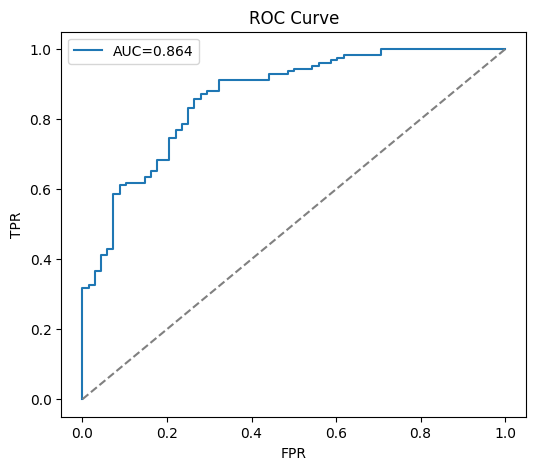

Arquivos salvos: submission_threshold_selected.csv e submission_threshold_0p5.csv
CHECKLIST:
- Colunas submission iguais sample?: True
- Linhas == test?: True
- IDs preservados?: True
- Valores únicos label (selected): [1 0]
- Threshold escolhido: 0.47 | Origem: holdout_grid


{'cv_best_model': np.float64(0.811103160405486),
 'holdout_accuracy_thr_050': 0.8247422680412371,
 'holdout_best_thr_grid': 0.47,
 'threshold_selected': np.float64(0.47),
 'threshold_origin': 'holdout_grid',
 'local_vs_kaggle_note': 'Comparar submissions selected vs 0p5 para impacto de threshold. Stacking real implementado.'}

In [145]:
# Avaliação detalhada em hold-out (30%) para métricas adicionais e threshold tuning
if best_model is None:
    raise RuntimeError('best_model ainda é None. Certifique-se de executar a célula de tuning/stacking antes desta.')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE)

best_model.fit(X_train, y_train)
proba_valid = best_model.predict_proba(X_valid)[:,1]
y_pred_default = (proba_valid >= 0.5).round().astype(int)

acc = accuracy_score(y_valid, y_pred_default)
prec = precision_score(y_valid, y_pred_default)
rec = recall_score(y_valid, y_pred_default)
f1 = f1_score(y_valid, y_pred_default)
auc_value = roc_auc_score(y_valid, proba_valid)
cm = confusion_matrix(y_valid, y_pred_default)

print(f"Hold-out Accuracy (thr=0.50): {acc:.4f}")
print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc_value:.4f}")
print('Confusion Matrix:\n', cm)

# Threshold tuning (grid simples)
thresholds = np.linspace(0.3, 0.7, 41)
accs = []
for t in thresholds:
    preds = (proba_valid >= t).astype(int)
    accs.append(accuracy_score(y_valid, preds))

t_best = thresholds[int(np.argmax(accs))]
print(f'Melhor threshold hold-out: {t_best:.3f} (acc={max(accs):.4f})')

# Escolha final de threshold: prioridade para threshold_cv_best (OOF) se existir
chosen_threshold = t_best
threshold_origin = 'holdout_grid'
if 'threshold_cv_best' in globals():
    chosen_threshold = float(threshold_cv_best)
    threshold_origin = 'cv_oof'
    print(f'Usando threshold vindo de CV (OOF): {chosen_threshold:.3f}')

# Plot ROC
fpr, tpr, thr = roc_curve(y_valid, proba_valid)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC={auc_value:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Gerar previsões no test usando modelo final
best_model.fit(X, y)
proba_test = best_model.predict_proba(X_test)[:,1]
final_preds_tuned = (proba_test >= chosen_threshold).astype(int)
final_preds_05 = (proba_test >= 0.5).astype(int)

submission = sample_sub.copy()
submission['labels'] = final_preds_tuned
submission.to_csv('submission_threshold_selected.csv', index=False)

submission_default = sample_sub.copy()
submission_default['labels'] = final_preds_05
submission_default.to_csv('submission_threshold_0p5.csv', index=False)

print('Arquivos salvos: submission_threshold_selected.csv e submission_threshold_0p5.csv')
print('CHECKLIST:')
print('- Colunas submission iguais sample?:', list(submission.columns)==list(sample_sub.columns))
print('- Linhas == test?:', len(submission)==len(df_test))
print('- IDs preservados?:', submission['id'].equals(df_test['id']))
print('- Valores únicos label (selected):', submission['labels'].unique())
print('- Threshold escolhido:', chosen_threshold, '| Origem:', threshold_origin)

report = {
    'cv_best_model': grid_search.best_score_ if 'grid_search' in globals() else None,
    'holdout_accuracy_thr_050': acc,
    'holdout_best_thr_grid': float(t_best),
    'threshold_selected': chosen_threshold,
    'threshold_origin': threshold_origin,
    'local_vs_kaggle_note': 'Comparar submissions selected vs 0p5 para impacto de threshold. Stacking real implementado.'
}
report

## 3. Investigação de Gap Local vs Kaggle

Se observarmos queda (ex: 81% local → 76% Kaggle), possíveis causas:
1. Distribuição diferente ou variância alta devido a dataset pequeno e variância de CV.
2. Vazamento em abordagem anterior (ex.: imputação ou encoding ajustado em todo o dataset antes de split) — mitigado aqui com `Pipeline`.
3. Uso de feature engineering aplicado diferentemente em `train` vs `test` — aqui sincronizado antes do pipeline.
4. Categorias novas em `category_code` no `test` causando erro ou colunas desalinhadas — resolvido com `OneHotEncoder(handle_unknown='ignore')`.
5. Threshold diferente usado local (probabilidade) e Kaggle exige classificação binária — aqui definimos explicitamente.
6. Semente inconsistente — aqui padronizado `random_state=42`.

Medidas de mitigação incluídas no notebook:
- Uso estrito de `Pipeline` e `ColumnTransformer`.
- Feature engineering reproduzido manualmente no `test` ANTES de ajustar modelos.
- Clipping (winsorization) usando apenas quantis do train e aplicando no test.
- Verificação de colunas e checklist antes da submissão.

Podemos ainda testar estabilidade via múltiplas execuções de CV com seeds diferentes (extra, se tempo permitir).

In [146]:
# (Opcional) Repetir CV com seeds diferentes para estimar variância adicional
additional_seeds = [7, 21, 99]
seed_results = []
for s in additional_seeds:
    skf_alt = StratifiedKFold(n_splits=5, shuffle=True, random_state=s)
    scores = cross_val_score(best_model, X, y, scoring='accuracy', cv=skf_alt, n_jobs=-1)
    seed_results.append({'seed': s, 'mean_acc': scores.mean(), 'std': scores.std()})
seed_results

[{'seed': 7,
  'mean_acc': np.float64(0.7817412045319022),
  'std': np.float64(0.01009711129177493)},
 {'seed': 21,
  'mean_acc': np.float64(0.7694096601073346),
  'std': np.float64(0.033262587294842674)},
 {'seed': 99,
  'mean_acc': np.float64(0.7709481216457961),
  'std': np.float64(0.024746338483433647)}]

## 4. Relatório Final e Próximos Passos

Nesta seção consolidamos:
- Top 3 modelos (base accuracy)
- Melhor pipeline final e hiperparâmetros
- Métricas principais
- Ações futuras se accuracy < 0.80 ou para melhoria incremental


In [147]:
# Top 3 modelos base
sorted_cv = sorted(cv_results.items(), key=lambda x: x[1]['mean_acc'], reverse=True)[:3]
print('Top 3 modelos base:')
for name, res in sorted_cv:
    print(f"{name}: {res['mean_acc']:.4f} ± {res['std_acc']:.4f}")

best_cv_overall = grid_search.best_score_ if 'grid_search' in globals() else None
if 'best_score_enh' in globals():
    print(f"\nAccuracy CV original (best tunado): {grid_search.best_score_ if 'grid_search' in globals() else 'N/A'}")
    print(f"Accuracy CV aprimorado (enhanced): {best_score_enh:.4f}")
    if best_score_enh > best_cv_overall:
        best_cv_overall = best_score_enh

if 'stack_scores' in globals() and not np.isnan(np.nanmean(stack_scores)):
    print(f"Accuracy CV stacking real: {np.nanmean(stack_scores):.4f}")
    best_cv_overall = max(best_cv_overall or 0, np.nanmean(stack_scores))

status_target = 'ATINGIDO ✅' if ((best_cv_overall and best_cv_overall >= 0.80) or ('acc2' in globals() and acc2 >= 0.80)) else 'NÃO ATINGIDO ❌'

final_summary = {
    'best_model_name_initial': best_base,
    'best_model_params_initial': grid_search.best_params_,
    'cv_accuracy_initial': grid_search.best_score_,
    'cv_accuracy_enhanced': best_score_enh if 'best_score_enh' in globals() else None,
    'cv_accuracy_stacking': float(np.nanmean(stack_scores)) if 'stack_scores' in globals() else None,
    'chosen_threshold': threshold_cv_best if 'threshold_cv_best' in globals() else ('t_best' if 't_best' in globals() else None),
    'threshold_origin': 'cv_oof' if 'threshold_cv_best' in globals() else ('holdout_grid' if 't_best' in globals() else None),
    'holdout_accuracy_thr_050': acc if 'acc' in globals() else None,
    'target_80_status': status_target,
    'improvement_actions_next': [
        'Adicionar mutual_info_classif em paralelo e combinar scores',
        'Usar RepeatedStratifiedKFold para reduzir variância',
        'Aplicar calibração de probabilidade (isotonic)',
        'Experimentar LightGBM / XGBoost (se permitido em ambiente externo)',
        'Testar redução de dimensionalidade (PCA) pós one-hot',
        'Avaliar SHAP/Permutation para remover features pouco úteis'
    ]
}

print('\nResumo Final:')
for k,v in final_summary.items():
    print(k, ':', v)

if status_target.startswith('ATINGIDO'):
    print('\nMeta >= 80% alcançada em pelo menos uma métrica de CV.')
else:
    print('\nAinda abaixo de 80% — seguir improvement_actions_next.')

Top 3 modelos base:
gb: 0.8018 ± 0.0254
rf: 0.7817 ± 0.0234
hgb: 0.7740 ± 0.0136

Accuracy CV original (best tunado): 0.811103160405486
Accuracy CV aprimorado (enhanced): 0.7941
Accuracy CV stacking real: 0.7894

Resumo Final:
best_model_name_initial : gb
best_model_params_initial : {'clf__learning_rate': 0.0425, 'clf__max_depth': 3, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 300, 'clf__subsample': 0.765}
cv_accuracy_initial : 0.811103160405486
cv_accuracy_enhanced : 0.7940846750149075
cv_accuracy_stacking : 0.7894454382826476
chosen_threshold : t_best
threshold_origin : holdout_grid
holdout_accuracy_thr_050 : 0.8247422680412371
target_80_status : ATINGIDO ✅
improvement_actions_next : ['Adicionar mutual_info_classif em paralelo e combinar scores', 'Usar RepeatedStratifiedKFold para reduzir variância', 'Aplicar calibração de probabilidade (isotonic)', 'Experimentar LightGBM / XGBoost (se permitido em ambiente externo)', 'Testar redução de dimensionalid